In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, Activation, BatchNormalization, Add, AveragePooling2D, Input, ZeroPadding2D, concatenate, GlobalAveragePooling2D, Lambda
from keras.initializers import glorot_uniform, Constant
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def conv2d(X, num_filters, filter_size, strides=1, padding="same", activation=True, name=None, kernel_initializer=None, bias_initializer=None):
    X = Conv2D(num_filters, filter_size, strides=strides, padding=padding, 
               kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(X)
    X = BatchNormalization(axis=3, scale=False)(X)
    if activation:
        X = Activation("relu")(X)
    return X

In [3]:
def Stem(input_layer, kernel_init, bias_init, name=None):
    X = conv2d(input_layer, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X = conv2d(X, 32, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X = conv2d(X, 64, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X1 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
    X2 = conv2d(X, 96, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X = concatenate([X1, X2], axis=3)
    
    X1 = conv2d(X, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X1 = conv2d(X1, 96, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X2 = conv2d(X2, 64, (7, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 64, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 96, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X = concatenate([X1, X2], axis=3)
    
    X1 = conv2d(X, 192, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X2 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
    X = concatenate([X1, X2], axis=3, name=name)
    
    return X

In [4]:
def InceptionResNet_A(X, kernel_init, bias_init, scaling_activation, scale=1, name=None):
    X_shortcut = X
    
    X1 = conv2d(X, 32, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X2 = conv2d(X, 32, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 32, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X3 = conv2d(X, 32, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X3 = conv2d(X3, 48, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X3 = conv2d(X3, 64, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X_inception = concatenate([X1, X2, X3], axis=3)
    
    X_inception = conv2d(X_inception, 384, (1, 1), strides=1, padding="same", activation=False, kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    
    final_layer = Lambda(lambda inputs: inputs[0] + inputs[1]*scale, name=name+"_Scaling_Residual")([X_shortcut, X_inception])

    final_layer = Activation("relu", name=name)(final_layer)
    
    return final_layer    

In [5]:
def InceptionResNet_B(X, kernel_init, bias_init, scaling_activation, scale=1, name=None):
    X_shortcut = X
    
    X1 = conv2d(X, 192, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X2 = conv2d(X, 128, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 160, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 192, (7, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X_inception = concatenate([X1, X2], axis=3)
    
    X_inception = conv2d(X_inception, 1152, (1, 1), strides=1, padding="same", activation=False, kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    final_layer = Lambda(lambda inputs: inputs[0] + inputs[1]*scale, name=name+"_Scaling_Residual")([X_shortcut, X_inception])

    final_layer = Activation("relu", name=name)(final_layer)

    return final_layer

In [6]:
def InceptionResNet_C(X, kernel_init, bias_init, scaling_activation, scale=1, name=None):
    X_shortcut = X
    
    X1 = conv2d(X, 192, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X2 = conv2d(X, 192, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 224, (1, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 256, (3, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X_inception = concatenate([X1, X2], axis=3)
    
    X_inception = conv2d(X_inception, 2048, (1, 1), strides=1, padding="same", activation=False, kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    final_layer = Lambda(lambda inputs: inputs[0] + inputs[1]*scale, name=name+"_Scaling_Residual")([X_shortcut, X_inception])

    final_layer = Activation("relu", name=name)(final_layer)
    
    return final_layer

In [7]:
def Reduction_A(X, kernel_init, bias_init, name=None):
    X1 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
    X2 = conv2d(X, 384, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X3 = conv2d(X, 256, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X3 = conv2d(X3, 256, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X3 = conv2d(X3, 384, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X = concatenate([X1, X2, X3], axis=3, name=name)
    
    return X    

In [8]:
def Reduction_B(X, kernel_init, bias_init, name=None):
    X1 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
    X2 = conv2d(X, 256, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X2 = conv2d(X2, 384, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X3 = conv2d(X, 256, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X3 = conv2d(X3, 256, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X4 = conv2d(X, 256, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X4 = conv2d(X4, 256, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X4 = conv2d(X4, 256, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X = concatenate([X1, X2, X3, X4], axis=3, name=name)
    
    return X

In [9]:
def InceptionResNet_V2(size=(299, 299, 3), N_classes=4):
    input_layer = Input(shape=size)
    kernel_init = glorot_uniform()
    bias_init = None
    
    X = Stem(input_layer, kernel_init, bias_init, name="Stem")
    
    X = InceptionResNet_A(X, kernel_init, bias_init, "relu", name="Block_A_1", scale=.15)
    X = InceptionResNet_A(X, kernel_init, bias_init, "relu", name="Block_A_2", scale=.15)
    X = InceptionResNet_A(X, kernel_init, bias_init, "relu", name="Block_A_3", scale=.15)
    X = InceptionResNet_A(X, kernel_init, bias_init, "relu", name="Block_A_4", scale=.15)
    X = InceptionResNet_A(X, kernel_init, bias_init, "relu", name="Block_A_5", scale=.15)
    
    X = Reduction_A(X, kernel_init, bias_init, name="Reduction_block_A")
    
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_1", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_2", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_3", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_4", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_5", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_6", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_7", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_8", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_9", scale=.1)
    X = InceptionResNet_B(X, kernel_init, bias_init, "relu", name="Block_B_10", scale=.1)
    
    X = Reduction_B(X, kernel_init, bias_init, name="Reduction_block_B")
    
    X = InceptionResNet_C(X, kernel_init, bias_init, "relu", name="Block_C_1", scale=.2)
    X = InceptionResNet_C(X, kernel_init, bias_init, "relu", name="Block_C_2", scale=.2)
    X = InceptionResNet_C(X, kernel_init, bias_init, "relu", name="Block_C_3", scale=.2)
    
    X = GlobalAveragePooling2D(name="GlobalAvgPool")(X)
    
    X = Dropout(.8)(X)
    
    X = Dense(N_classes, activation="softmax", name="final_output")(X)
    
    model = Model(input_layer, X, name="InceptionResNet_V2")
    
    return model

In [21]:
import os
?os.mkdir

In [10]:
import math, pickle

In [18]:
params = [{'samplewise_center':1, 'samplewise_std_normalization':1}, {'featurewise_center':1, 'featurewise_std_normalization':1}, {'rescale':1./255.}]
label = ["samplewise center and std", "featurewise center and std", "rescale by 255"]
opt = "SGD"
num_epochs = 150

Found 975 images belonging to 5 classes.
Found 235 images belonging to 5 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/150
49/49 [==============================] - 44s 892ms/step - loss: 4.7249 - accuracy: 0.3703 - val_loss: 8.1595 - val_accuracy: 0.2894

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/150
49/49 [==============================] - 35s 713ms/step - loss: 2.0244 - accuracy: 0.5846 - val_loss: 1.8523 - val_accuracy: 0.5234

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/150
49/49 [==============================] - 32s 658ms/step - loss: 1.6529 - accuracy: 0.6431 - val_loss: 3.2562 - val_accuracy: 0.4213

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/150
49/49 [==============================] - 32s 655ms/step - loss: 1.2990 - accuracy: 0.7097 - val_loss: 2.0423 - va

49/49 [==============================] - 31s 641ms/step - loss: 0.0499 - accuracy: 0.9795 - val_loss: 0.2621 - val_accuracy: 0.9362

Epoch 00073: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 73/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.8903 - val_accuracy: 0.8213

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0145 - accuracy: 0.9949 - val_loss: 0.6435 - val_accuracy: 0.8766

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0310 - accuracy: 0.9877 - val_loss: 0.2382 - val_accuracy: 0.9404

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0426 - accuracy: 0.986

49/49 [==============================] - 31s 641ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.6039 - val_accuracy: 0.8894

Epoch 00109: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 109/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.7660 - val_accuracy: 0.8809

Epoch 00110: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 110/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.5392 - val_accuracy: 0.9277

Epoch 00111: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 111/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.4495 - val_accuracy: 0.9191

Epoch 00112: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 112/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0105 - accuracy: 0

49/49 [==============================] - 31s 641ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.4844 - val_accuracy: 0.9149

Epoch 00145: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 145/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.4961 - val_accuracy: 0.9191

Epoch 00146: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 146/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 0.4310 - val_accuracy: 0.9234

Epoch 00147: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 147/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.5178 - val_accuracy: 0.9191

Epoch 00148: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 148/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0040 - accuracy: 0

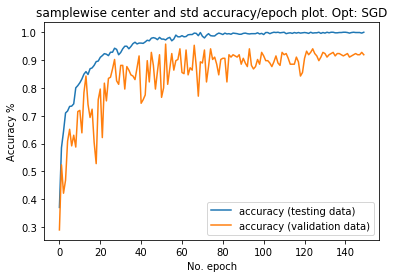

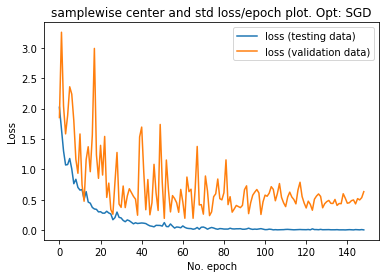

Found 975 images belonging to 5 classes.
Found 235 images belonging to 5 classes.


/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/150


/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


49/49 [==============================] - 41s 844ms/step - loss: 6.2449 - accuracy: 0.1928 - val_loss: 102.8209 - val_accuracy: 0.1277

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/150
49/49 [==============================] - 34s 700ms/step - loss: 5.0738 - accuracy: 0.2226 - val_loss: 81.3254 - val_accuracy: 0.1702

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/150
49/49 [==============================] - 32s 654ms/step - loss: 3.8710 - accuracy: 0.2615 - val_loss: 21.5892 - val_accuracy: 0.2340

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/150
49/49 [==============================] - 31s 640ms/step - loss: 4.7192 - accuracy: 0.2697 - val_loss: 47.6891 - val_accuracy: 0.2128

Epoch 00005: LearningRateScheduler setting learning rate to 0.019.
Epoch 5/150
49/49 [==============================] - 31s 640ms/step - loss: 3.6562 - accuracy: 0.2697 - val_loss: 47.8646 - val_accuracy: 0.1957

Epoch 00006: Le

49/49 [==============================] - 31s 640ms/step - loss: 1.0488 - accuracy: 0.6503 - val_loss: 1.2851 - val_accuracy: 0.5872

Epoch 00039: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 39/150
49/49 [==============================] - 31s 640ms/step - loss: 0.8875 - accuracy: 0.6564 - val_loss: 5.4542 - val_accuracy: 0.2936

Epoch 00040: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 40/150
49/49 [==============================] - 32s 655ms/step - loss: 0.8805 - accuracy: 0.6646 - val_loss: 1.1733 - val_accuracy: 0.5319

Epoch 00041: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 41/150
49/49 [==============================] - 31s 640ms/step - loss: 0.9379 - accuracy: 0.6728 - val_loss: 3.7001 - val_accuracy: 0.2936

Epoch 00042: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 42/150
49/49 [==============================] - 31s 640ms/step - loss: 0.8453 - accuracy: 0.684

49/49 [==============================] - 31s 640ms/step - loss: 0.5295 - accuracy: 0.8267 - val_loss: 0.8997 - val_accuracy: 0.6723

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/150
49/49 [==============================] - 31s 640ms/step - loss: 0.5594 - accuracy: 0.8062 - val_loss: 1.0573 - val_accuracy: 0.7106

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/150
49/49 [==============================] - 31s 640ms/step - loss: 0.5691 - accuracy: 0.7887 - val_loss: 1.1139 - val_accuracy: 0.7106

Epoch 00077: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 77/150
49/49 [==============================] - 31s 640ms/step - loss: 0.5395 - accuracy: 0.8133 - val_loss: 1.5364 - val_accuracy: 0.5149

Epoch 00078: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 78/150
49/49 [==============================] - 31s 639ms/step - loss: 0.4754 - accuracy: 0.831

49/49 [==============================] - 31s 640ms/step - loss: 0.2940 - accuracy: 0.8810 - val_loss: 1.0502 - val_accuracy: 0.6383

Epoch 00111: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 111/150
49/49 [==============================] - 31s 640ms/step - loss: 0.2907 - accuracy: 0.8985 - val_loss: 0.8062 - val_accuracy: 0.7234

Epoch 00112: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 112/150
49/49 [==============================] - 31s 640ms/step - loss: 0.2903 - accuracy: 0.9056 - val_loss: 0.7124 - val_accuracy: 0.7149

Epoch 00113: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 113/150
49/49 [==============================] - 31s 640ms/step - loss: 0.2825 - accuracy: 0.8995 - val_loss: 0.7234 - val_accuracy: 0.7191

Epoch 00114: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 114/150
49/49 [==============================] - 31s 640ms/step - loss: 0.2656 - accuracy: 0

49/49 [==============================] - 31s 640ms/step - loss: 0.1632 - accuracy: 0.9477 - val_loss: 0.7404 - val_accuracy: 0.7872

Epoch 00147: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 147/150
49/49 [==============================] - 31s 640ms/step - loss: 0.1691 - accuracy: 0.9385 - val_loss: 0.5859 - val_accuracy: 0.7872

Epoch 00148: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 148/150
49/49 [==============================] - 31s 640ms/step - loss: 0.1562 - accuracy: 0.9508 - val_loss: 0.7093 - val_accuracy: 0.7915

Epoch 00149: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 149/150
49/49 [==============================] - 31s 639ms/step - loss: 0.1944 - accuracy: 0.9395 - val_loss: 0.7891 - val_accuracy: 0.7745

Epoch 00150: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 150/150
49/49 [==============================] - 31s 640ms/step - loss: 0.1700 - accuracy: 0

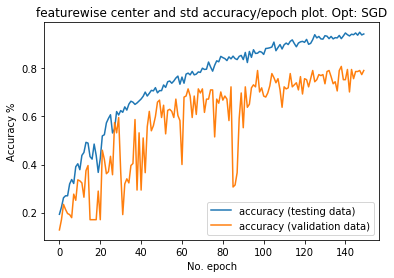

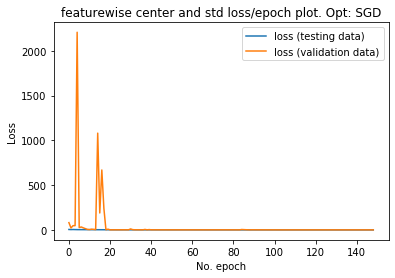

Found 975 images belonging to 5 classes.
Found 235 images belonging to 5 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/150
49/49 [==============================] - 42s 848ms/step - loss: 6.1279 - accuracy: 0.2287 - val_loss: 26.2878 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/150
49/49 [==============================] - 32s 655ms/step - loss: 5.2543 - accuracy: 0.2082 - val_loss: 22.2215 - val_accuracy: 0.2000

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/150
49/49 [==============================] - 32s 654ms/step - loss: 5.0488 - accuracy: 0.2451 - val_loss: 11.3108 - val_accuracy: 0.1702

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/150
49/49 [==============================] - 32s 654ms/step - loss: 5.0104 - accuracy: 0.1959 - val_loss: 2.0914 -

49/49 [==============================] - 31s 640ms/step - loss: 0.4720 - accuracy: 0.8308 - val_loss: 0.8943 - val_accuracy: 0.6596

Epoch 00073: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 73/150
49/49 [==============================] - 31s 641ms/step - loss: 0.5012 - accuracy: 0.8338 - val_loss: 0.8208 - val_accuracy: 0.6766

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/150
49/49 [==============================] - 31s 640ms/step - loss: 0.4373 - accuracy: 0.8472 - val_loss: 1.4253 - val_accuracy: 0.5660

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/150
49/49 [==============================] - 31s 640ms/step - loss: 0.4372 - accuracy: 0.8585 - val_loss: 0.6455 - val_accuracy: 0.7660

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/150
49/49 [==============================] - 31s 640ms/step - loss: 0.3863 - accuracy: 0.864

49/49 [==============================] - 31s 640ms/step - loss: 0.1878 - accuracy: 0.9374 - val_loss: 0.7480 - val_accuracy: 0.7489

Epoch 00109: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 109/150
49/49 [==============================] - 31s 640ms/step - loss: 0.1673 - accuracy: 0.9436 - val_loss: 0.8253 - val_accuracy: 0.7362

Epoch 00110: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 110/150
49/49 [==============================] - 31s 640ms/step - loss: 0.1953 - accuracy: 0.9426 - val_loss: 0.6542 - val_accuracy: 0.7319

Epoch 00111: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 111/150
49/49 [==============================] - 31s 640ms/step - loss: 0.1851 - accuracy: 0.9364 - val_loss: 0.5962 - val_accuracy: 0.7574

Epoch 00112: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 112/150
49/49 [==============================] - 31s 641ms/step - loss: 0.1757 - accuracy: 0

49/49 [==============================] - 31s 641ms/step - loss: 0.0871 - accuracy: 0.9713 - val_loss: 0.3775 - val_accuracy: 0.8723

Epoch 00145: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 145/150
49/49 [==============================] - 31s 640ms/step - loss: 0.0853 - accuracy: 0.9744 - val_loss: 0.4639 - val_accuracy: 0.8340

Epoch 00146: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 146/150
49/49 [==============================] - 31s 640ms/step - loss: 0.0865 - accuracy: 0.9713 - val_loss: 0.7864 - val_accuracy: 0.7447

Epoch 00147: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 147/150
49/49 [==============================] - 31s 641ms/step - loss: 0.0914 - accuracy: 0.9733 - val_loss: 0.6024 - val_accuracy: 0.7830

Epoch 00148: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 148/150
49/49 [==============================] - 31s 640ms/step - loss: 0.0854 - accuracy: 0

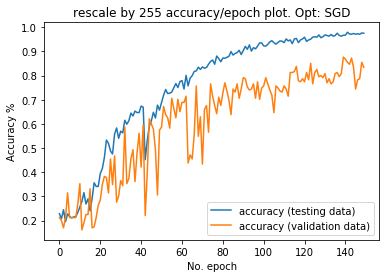

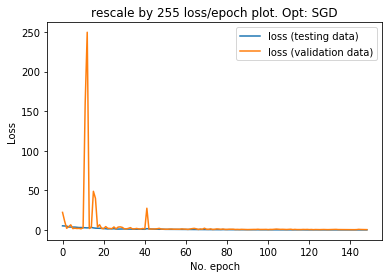

In [19]:
os.mkdir("Weights/" + opt)
os.mkdir("Hist/" + opt)
os.mkdir("Plots/" + opt)
for i, el in enumerate(params):
    nn = InceptionResNet_V2(size=(299, 299, 3), N_classes=5)
    
    initial_lrate = .02
    def decay(epoch, steps=100):
        init_rate = .02
        drop = .95
        epochs_drop = 4
        lrate = init_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lrate

    RMS = SGD(lr=initial_lrate)

    scheduler = LearningRateScheduler(decay, verbose=True)
    
    mcp_save = ModelCheckpoint("Weights/"+ opt + "/" + "InceptionResNetV2_" + label[i].replace(" ", "_") + "_" + str(num_epochs) + "epochs_BEST.h5", save_best_only=True, monitor='val_loss', mode='min')

    nn.compile(loss=["categorical_crossentropy"], optimizer=RMS, metrics=["accuracy"])
    
    gen1 = image.ImageDataGenerator(zoom_range=.15, vertical_flip=True, horizontal_flip=True, brightness_range=[.15, 1], rotation_range=30, **params[i])
    gen2 = image.ImageDataGenerator(**params[i])
    
    train = gen1.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/SelfCutData/", batch_size=20, target_size=(299, 299), shuffle=1)
    test = gen2.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/Test/", batch_size=20, target_size=(299, 299), shuffle=1)
    
    hist = nn.fit_generator(train, validation_data=test, epochs=num_epochs, verbose=1, callbacks=[scheduler, mcp_save])
    
    nn.save_weights("Weights/"+ opt + "/" + "InceptionResNetV2_" + label[i].replace(" ", "_") + str(num_epochs) + "epochs.h5")
    
    with open("Hist/"+ opt + "/" + "InceptionResNetV2_" + label[i].replace(" ", "_") + "_" + str(num_epochs) + "epochs.pickle", "wb") as f:
        pickle.dump(hist.history, f)
        
    plt.plot(hist.history['accuracy'], label='accuracy (testing data)')
    plt.plot(hist.history['val_accuracy'], label='accuracy (validation data)')
    plt.title(label[i]+ " accuracy/epoch plot." + " Opt: {}".format(opt))
    plt.ylabel('Accuracy %')
    plt.xlabel('No. epoch')
    plt.legend(loc="lower right")
    plt.show()
    
    
    plt.plot(hist.history['loss'][1:], label='loss (testing data)')
    plt.plot(hist.history['val_loss'][1:], label='loss (validation data)')
    plt.title(label[i] + " loss/epoch plot." + " Opt: {}".format(opt))
    plt.ylabel('Loss')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.show()
    

In [10]:
nn = InceptionResNet_V2(size=(299, 299, 3), N_classes=5)
nn.summary()

Model: "InceptionResNet_V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_________________________________________________________________________________

In [19]:
import math
initial_lrate = .01
def decay(epoch, steps=100):
    init_rate = .01
    drop = .96
    epochs_drop = 2
    lrate = init_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

RMS = RMSprop(lr=initial_lrate)

scheduler = LearningRateScheduler(decay, verbose=True)

nn.compile(loss=["categorical_crossentropy"], optimizer=RMS, metrics=["accuracy"])

In [51]:
gen1 = image.ImageDataGenerator(featurewise_center=1, featurewise_std_normalization=1, zoom_range=.15, vertical_flip=True, horizontal_flip=True, brightness_range=[.15, 1], rotation_range=30)

In [52]:
gen2 = image.ImageDataGenerator(featurewise_center=1, featurewise_std_normalization=1)

In [53]:
train = gen1.flow_from_directory("SelfCutData/SelfCutData/", batch_size=20, target_size=(299, 299), shuffle=1)

Found 975 images belonging to 5 classes.


In [54]:
test = gen2.flow_from_directory("SelfCutData/Test/", batch_size=20, target_size=(299, 299), shuffle=1)

Found 235 images belonging to 5 classes.


In [ ]:
hist1 = nn.fit_generator(train, validation_data=test, epochs=150, verbose=1, callbacks=[scheduler])

/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/150


/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


49/49 [==============================] - 52s 1s/step - loss: 7.9688 - accuracy: 0.2051 - val_loss: 2545451925.3333 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.0096.
Epoch 2/150
49/49 [==============================] - 33s 672ms/step - loss: 5.1295 - accuracy: 0.2308 - val_loss: 5390452096.0000 - val_accuracy: 0.1702

Epoch 00003: LearningRateScheduler setting learning rate to 0.0096.
Epoch 3/150
49/49 [==============================] - 34s 687ms/step - loss: 4.3619 - accuracy: 0.2185 - val_loss: 20092300.1667 - val_accuracy: 0.1702

Epoch 00004: LearningRateScheduler setting learning rate to 0.009216.
Epoch 4/150
49/49 [==============================] - 33s 674ms/step - loss: 4.6874 - accuracy: 0.2410 - val_loss: 12510541.3333 - val_accuracy: 0.1702

Epoch 00005: LearningRateScheduler setting learning rate to 0.009216.
Epoch 5/150
49/49 [==============================] - 33s 678ms/step - loss: 3.5850 - accuracy: 0.2215 - val_loss: 933.2488 - va

49/49 [==============================] - 33s 676ms/step - loss: 0.4576 - accuracy: 0.8482 - val_loss: 1.7290 - val_accuracy: 0.4979

Epoch 00074: LearningRateScheduler setting learning rate to 0.0022081858492852095.
Epoch 74/150
49/49 [==============================] - 33s 676ms/step - loss: 0.4215 - accuracy: 0.8533 - val_loss: 0.9658 - val_accuracy: 0.6468

Epoch 00075: LearningRateScheduler setting learning rate to 0.0022081858492852095.
Epoch 75/150
43/49 [=========================>....] - ETA: 3s - loss: 0.4456 - accuracy: 0.8526

In [12]:
mcp_save = ModelCheckpoint('InceptionResNet_v2_scaled.h5', save_best_only=True, monitor='val_loss', mode='min')

In [24]:
generator = image.ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
generator1 = image.ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

In [23]:
Train = gen1.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/SelfCutData/", target_size=(299, 299), shuffle=True, batch_size=20)

Found 975 images belonging to 5 classes.


In [25]:
Test = generator1.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/TestMod//", target_size=(299, 299), shuffle=False, batch_size=10)

Found 134 images belonging to 5 classes.


In [25]:
hist = nn.fit_generator(Train, validation_data=Test, epochs = 100, verbose = 1, callbacks=[scheduler])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 49 steps, validate for 24 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100


49/49 [==============================] - 55s 1s/step - loss: 4.4093 - accuracy: 0.3169 - val_loss: 3252880213.3333 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.0096.
Epoch 2/100
49/49 [==============================] - 33s 675ms/step - loss: 2.6396 - accuracy: 0.3590 - val_loss: 7405578.2292 - val_accuracy: 0.2128

Epoch 00003: LearningRateScheduler setting learning rate to 0.0096.
Epoch 3/100
49/49 [==============================] - 33s 676ms/step - loss: 2.4932 - accuracy: 0.3744 - val_loss: 1396923.4870 - val_accuracy: 0.2128

Epoch 00004: LearningRateScheduler setting learning rate to 0.009216.
Epoch 4/100
49/49 [==============================] - 33s 677ms/step - loss: 2.5774 - accuracy: 0.3785 - val_loss: 5271.6171 - val_accuracy: 0.2213

Epoch 00005: LearningRateScheduler setting learning rate to 0.009216.
Epoch 5/100
49/49 [==============================] - 33s 677ms/step - loss: 2.3259 - accuracy: 0.4185 - val_loss: 40000.8094 - val_accu

49/49 [==============================] - 34s 685ms/step - loss: 0.0960 - accuracy: 0.9733 - val_loss: 0.3477 - val_accuracy: 0.9404

Epoch 00074: LearningRateScheduler setting learning rate to 0.0022081858492852095.
Epoch 74/100
49/49 [==============================] - 33s 678ms/step - loss: 0.0611 - accuracy: 0.9774 - val_loss: 0.6744 - val_accuracy: 0.8809

Epoch 00075: LearningRateScheduler setting learning rate to 0.0022081858492852095.
Epoch 75/100
49/49 [==============================] - 33s 679ms/step - loss: 0.0745 - accuracy: 0.9815 - val_loss: 0.9414 - val_accuracy: 0.8383

Epoch 00076: LearningRateScheduler setting learning rate to 0.0021198584153138017.
Epoch 76/100
49/49 [==============================] - 33s 680ms/step - loss: 0.0705 - accuracy: 0.9764 - val_loss: 1.2824 - val_accuracy: 0.7787

Epoch 00077: LearningRateScheduler setting learning rate to 0.0021198584153138017.
Epoch 77/100
49/49 [==============================] - 34s 690ms/step - loss: 0.0502 - accuracy: 0

In [43]:
import matplotlib.pyplot as plt

## Samplewise normed

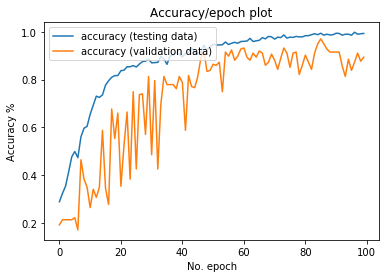

In [59]:
plt.plot(hist1.history['accuracy'], label='accuracy (testing data)')
plt.plot(hist1.history['val_accuracy'], label='accuracy (validation data)')
plt.title('Accuracy/epoch plot')
plt.ylabel('Accuracy %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Rescale by 1./255.

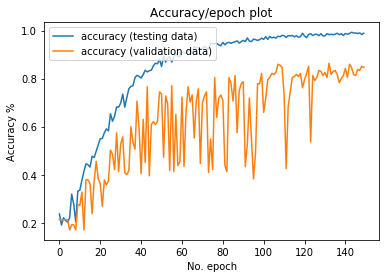

In [44]:
plt.plot(hist1.history['accuracy'], label='accuracy (testing data)')
plt.plot(hist1.history['val_accuracy'], label='accuracy (validation data)')
plt.title('Accuracy/epoch plot')
plt.ylabel('Accuracy %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [38]:
import pickle

In [39]:
with open("history09_04_20.pickle", 'wb') as f:
    pickle.dump(hist.history, f)

In [22]:
nn.load_weights("Weights/SGD/InceptionResNetV2_samplewise_center_and_std_150epochs_BEST.h5")

In [27]:
nn.evaluate_generator(Test, verbose=1)

  ...
    to  
  ['...']
14/14 [==============================] - 2s 111ms/step - loss: 0.0564 - accuracy: 0.9925


[0.05638507887568624, 0.9925373]